In [1]:
import os
import pickle

import bargo.utils as utils
import bargo.engine as engine

from sympy import *
from scipy.special import jn, jn_zeros
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score

2024-01-12 21:50:12.898354: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
u_sym = Symbol('u')
v_sym = Symbol('v')

x_sym = 1 / 2 * (sqrt(2 + u_sym**2 - v_sym**2 + sqrt(8) * u_sym) - sqrt(2 + u_sym**2 - v_sym**2 - sqrt(8) * u_sym))
y_sym = 1 / 2 * (sqrt(2 - u_sym**2 + v_sym**2 + sqrt(8) * v_sym) - sqrt(2 - u_sym**2 + v_sym**2 - sqrt(8) * v_sym))

In [3]:
X_sym = Symbol('X')
Y_sym = Symbol('Y')

U_sym = X_sym * sqrt(1 - Y_sym**2 / 2)
V_sym = Y_sym * sqrt(1 - X_sym**2 / 2)

In [4]:
N = 100
    
a = 1
h = 2 * a / (N - 1)

mesh = []
mask = []
for i in range(N):
    for j in range(N):
        x = -a + i * h
        y = -a + j * h
        mesh.append([x, y])
        mask.append(not (i==0 or j==0 or i==N-1 or j==N-1))

mask = np.reshape(mask, (N, N))
X = np.array(mesh)

In [5]:
Y = np.array(
    [[
        float(U_sym.subs({X_sym: m[0], Y_sym: m[1]})),
        float(V_sym.subs({X_sym: m[0], Y_sym: m[1]}))
    ]
    for m in mesh]
)

(<Figure size 500x500 with 1 Axes>, <AxesSubplot:>)

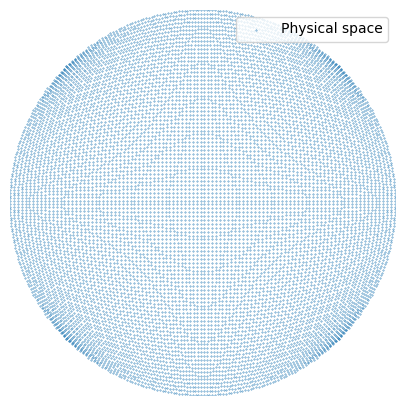

In [6]:
utils.scatter([('Physical space', Y)], figsize=(5, 5))

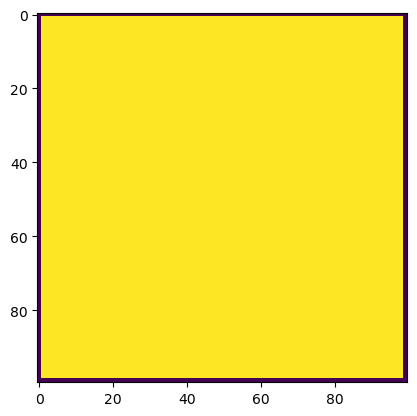

In [7]:
plt.imshow(mask)

In [8]:
# dxdu = diff(x_sym, u_sym)
# dxdv = diff(x_sym, v_sym)
# dydu = diff(y_sym, u_sym)
# dydv = diff(y_sym, v_sym)
dudx = diff(U_sym, X_sym)
dudy = diff(U_sym, Y_sym)
dvdx = diff(V_sym, X_sym)
dvdy = diff(V_sym, Y_sym)

J_sym = Matrix([
    [dudx, dudy],
    [dvdx, dvdy]
])

dJ_sym = [
    diff(J_sym, X_sym),
    diff(J_sym, Y_sym)
]

In [9]:
Y

array([[-0.70710678, -0.70710678],
       [-0.72110884, -0.6928218 ],
       [-0.7345664 , -0.67853681],
       ...,
       [ 0.7345664 ,  0.67853681],
       [ 0.72110884,  0.6928218 ],
       [ 0.70710678,  0.70710678]])

In [10]:
J_sym

Matrix([
[         sqrt(1 - Y**2/2), -X*Y/(2*sqrt(1 - Y**2/2))],
[-X*Y/(2*sqrt(1 - X**2/2)),          sqrt(1 - X**2/2)]])

In [11]:
np.array(J_sym.subs({X_sym: X[0,0], Y_sym: X[0,1]})).astype(float)

array([[ 0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

In [12]:
Js = []
dJs = []
for i in tqdm(range(len(X))):
    if not mask.flatten()[i]:
        Js.append(np.identity(2))
        dJs.append(np.zeros_like(dJ_sym, dtype=float))
    else:
        # Js.append(np.array(J_sym.subs({u_sym: Y[i, 0], v_sym: Y[i, 1]})).astype(float))
        # dJs.append([
        #     np.array(dJ_sym[0].subs({u_sym: Y[i, 0], v_sym: Y[i, 1]})).astype(float),
        #     np.array(dJ_sym[1].subs({u_sym: Y[i, 0], v_sym: Y[i, 1]})).astype(float)
        # ])
        Js.append(np.array(J_sym.subs({X_sym: X[i, 0], Y_sym: X[i, 1]})).astype(float))
        dJs.append([
            np.array(dJ_sym[0].subs({X_sym: X[i, 0], Y_sym: X[i, 1]})).astype(float),
            np.array(dJ_sym[1].subs({X_sym: X[i, 0], Y_sym: X[i, 1]})).astype(float)
        ])
Js = np.array(Js)
dJs = np.array(dJs)

100%|██████████| 10000/10000 [00:43<00:00, 230.00it/s]


In [13]:
Gs_inv, Ws = engine.cast_metric(Js, dJs)

In [14]:
n = 1
k = 2

def l(n, k):
    return jn_zeros(n, k)[-1]

def f(x, y):
    r = np.sqrt(x**2 + y**2)
    p = np.arctan2(y, x)
    return jn(n, l(n, k) * r) * np.cos(n * p)

In [15]:
solver = engine.FDSolver(Y, mask, Gs_inv, Ws, h, f, [1], 'helmholtz')

In [16]:
L = solver.get_fd_matrix()
b = solver.get_rhs()

In [17]:
u = np.linalg.inv(L) @ b

In [18]:
u_exact = b / (1 - l(n, k)**2)
f'{1-r2_score(u_exact, u): .3e}'

' 8.974e-05'

In [19]:
mask.sum()

9604

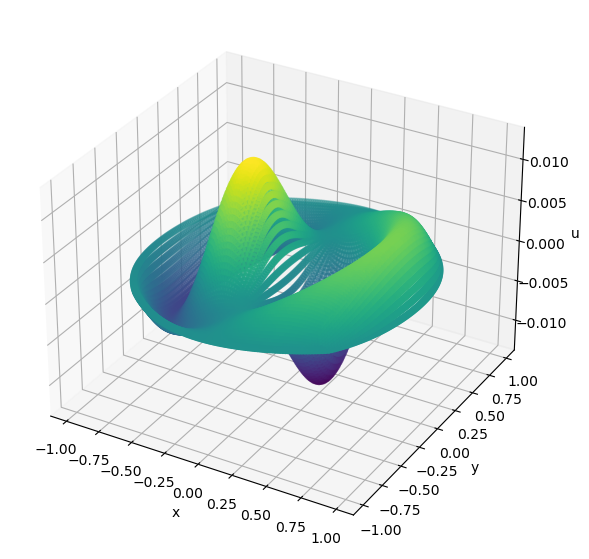

In [20]:
fig, ax = solver.plot(u)